# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import *
#from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 2
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels, classes = create_labeled_training_classes(training_data, classification, workload)
test_data_labels = create_labeled_test_validation_classes(test_data, classes, workload)
validation_data_labels = create_labeled_test_validation_classes(validation_data, classes, workload)

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)
        #print(predictions, labels)
        
        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [8]:
EPOCHS = 7000
initial_number_of_circuits = 20
syms = {}
limit = False
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:initial_number_of_circuits + 1]
current_training_circuits = {}
result_file = workload + "_" + workload_size + "_noisyopt_6_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params)

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
if initial_number_of_circuits > 10 and os.path.exists("points//" + result_file + ".npz"):
    with open("points//" + result_file + ".npz", "rb") as f:
        print("Loading parameters from file " + result_file)
        npzfile = np.load(f)
        init_params_spsa = npzfile['arr_0']
else:
    print("Initializing new parameters")
    init_params_spsa = np.array(rng.random(len(parameters)))
result = None
run = 0

Initializing new parameters


Progress:  0.045
Number of training circuits: 21   Number of validation circuits: 80   Number of test circuits: 70   Number of parameters in model: 174
0.01 0.01


Epoch: 200   train/loss: 5.7355   valid/loss: 27.872   train/acc: 0.4762   valid/acc: 0.3625
Epoch: 400   train/loss: 4.4796   valid/loss: 31.1839   train/acc: 0.7143   valid/acc: 0.325
Epoch: 600   train/loss: 3.9808   valid/loss: 33.7346   train/acc: 0.7619   valid/acc: 0.35
Epoch: 800   train/loss: 3.499   valid/loss: 32.5579   train/acc: 0.8095   valid/acc: 0.35
Epoch: 1000   train/loss: 3.2899   valid/loss: 34.3295   train/acc: 0.8095   valid/acc: 0.3125
Epoch: 1200   train/loss: 3.0606   valid/loss: 35.0156   train/acc: 0.8095   valid/acc: 0.3125
Epoch: 1400   train/loss: 2.9501   valid/loss: 38.7849   train/acc: 0.8095   valid/acc: 0.325
Epoch: 1600   train/loss: 2.8762   valid/loss: 37.7363   train/acc: 0.8095   valid/acc: 0.325
Epoch: 1800   train/loss: 2.6833   valid/loss: 40.1522   train/acc: 0.8095   valid/acc: 0.3875
Epoch: 2000   train/loss: 2.5498   valid/loss: 42.0977   train/acc: 0.8095   valid/acc: 0.3875
Epoch: 2200   train/loss: 2.5455   valid/loss: 41.0079   train/

Test accuracy: 0.3
Progress:  0.047
Number of training circuits: 22   Number of validation circuits: 80   Number of test circuits: 70   Number of parameters in model: 174
Progress:  0.049
Number of training circuits: 23   Number of validation circuits: 80   Number of test circuits: 70   Number of parameters in model: 174
Progress:  0.051
Number of training circuits: 24   Number of validation circuits: 81   Number of test circuits: 73   Number of parameters in model: 186
Progress:  0.054
Number of training circuits: 25   Number of validation circuits: 81   Number of test circuits: 73   Number of parameters in model: 186
Progress:  0.056
Number of training circuits: 26   Number of validation circuits: 81   Number of test circuits: 73   Number of parameters in model: 186
Progress:  0.058
Number of training circuits: 27   Number of validation circuits: 83   Number of test circuits: 77   Number of parameters in model: 189
Progress:  0.06
Number of training circuits: 28   Number of validatio

Epoch: 200   train/loss: 11.1539   valid/loss: 32.119   train/acc: 0.3846   valid/acc: 0.2857
Epoch: 400   train/loss: 10.4777   valid/loss: 36.5549   train/acc: 0.5385   valid/acc: 0.3407
Epoch: 600   train/loss: 10.2984   valid/loss: 36.1053   train/acc: 0.5641   valid/acc: 0.2198
Epoch: 800   train/loss: 9.7123   valid/loss: 38.2167   train/acc: 0.5385   valid/acc: 0.2637
Epoch: 1000   train/loss: 9.6894   valid/loss: 36.977   train/acc: 0.5641   valid/acc: 0.2857
Epoch: 1200   train/loss: 9.1662   valid/loss: 37.8125   train/acc: 0.6154   valid/acc: 0.2857
Epoch: 1400   train/loss: 8.9177   valid/loss: 36.7168   train/acc: 0.641   valid/acc: 0.3626
Epoch: 1600   train/loss: 8.9696   valid/loss: 36.1538   train/acc: 0.641   valid/acc: 0.3626
Epoch: 1800   train/loss: 8.8301   valid/loss: 37.3852   train/acc: 0.641   valid/acc: 0.3846
Epoch: 2000   train/loss: 8.7195   valid/loss: 36.1178   train/acc: 0.6667   valid/acc: 0.3626
Epoch: 2200   train/loss: 8.9067   valid/loss: 34.9616  

Test accuracy: 0.29545454545454547
Progress:  0.089
Number of training circuits: 40   Number of validation circuits: 91   Number of test circuits: 88   Number of parameters in model: 204
Progress:  0.092
Number of training circuits: 41   Number of validation circuits: 92   Number of test circuits: 88   Number of parameters in model: 207
Progress:  0.094
Number of training circuits: 42   Number of validation circuits: 92   Number of test circuits: 88   Number of parameters in model: 207
Progress:  0.096
Number of training circuits: 43   Number of validation circuits: 92   Number of test circuits: 88   Number of parameters in model: 207
Progress:  0.098
Number of training circuits: 44   Number of validation circuits: 92   Number of test circuits: 90   Number of parameters in model: 210
Progress:  0.1
Number of training circuits: 45   Number of validation circuits: 92   Number of test circuits: 90   Number of parameters in model: 210
Progress:  0.103
Number of training circuits: 46   Numb

Epoch: 200   train/loss: 17.8599   valid/loss: 37.3281   train/acc: 0.3729   valid/acc: 0.301
Epoch: 400   train/loss: 19.3387   valid/loss: 37.1172   train/acc: 0.2373   valid/acc: 0.301
Epoch: 600   train/loss: 16.7987   valid/loss: 37.6673   train/acc: 0.3898   valid/acc: 0.2427
Epoch: 800   train/loss: 15.1519   valid/loss: 37.0953   train/acc: 0.5085   valid/acc: 0.2621
Epoch: 1000   train/loss: 13.5866   valid/loss: 39.414   train/acc: 0.6102   valid/acc: 0.2913
Epoch: 1200   train/loss: 13.176   valid/loss: 39.5671   train/acc: 0.5593   valid/acc: 0.3204
Epoch: 1400   train/loss: 13.3111   valid/loss: 39.0026   train/acc: 0.5593   valid/acc: 0.3301
Epoch: 1600   train/loss: 12.7998   valid/loss: 39.1458   train/acc: 0.5593   valid/acc: 0.3398
Epoch: 1800   train/loss: 12.7021   valid/loss: 39.0917   train/acc: 0.6102   valid/acc: 0.3301
Epoch: 2000   train/loss: 12.4067   valid/loss: 39.5196   train/acc: 0.5932   valid/acc: 0.3107
Epoch: 2200   train/loss: 13.0466   valid/loss: 

Test accuracy: 0.33
Progress:  0.134
Number of training circuits: 60   Number of validation circuits: 103   Number of test circuits: 100   Number of parameters in model: 219
Progress:  0.136
Number of training circuits: 61   Number of validation circuits: 103   Number of test circuits: 100   Number of parameters in model: 219
Progress:  0.138
Number of training circuits: 62   Number of validation circuits: 103   Number of test circuits: 100   Number of parameters in model: 219
Progress:  0.141
Number of training circuits: 63   Number of validation circuits: 103   Number of test circuits: 100   Number of parameters in model: 219
Progress:  0.143
Number of training circuits: 64   Number of validation circuits: 103   Number of test circuits: 100   Number of parameters in model: 219
Progress:  0.145
Number of training circuits: 65   Number of validation circuits: 103   Number of test circuits: 100   Number of parameters in model: 219
Progress:  0.147
Number of training circuits: 66   Numbe

Epoch: 200   train/loss: 25.0419   valid/loss: 37.2254   train/acc: 0.4304   valid/acc: 0.2762
Epoch: 400   train/loss: 24.5539   valid/loss: 38.4577   train/acc: 0.2785   valid/acc: 0.2476
Epoch: 600   train/loss: 23.5463   valid/loss: 37.7887   train/acc: 0.4051   valid/acc: 0.3238
Epoch: 800   train/loss: 22.9747   valid/loss: 35.7297   train/acc: 0.4557   valid/acc: 0.3333
Epoch: 1000   train/loss: 21.7777   valid/loss: 38.0868   train/acc: 0.4684   valid/acc: 0.3619
Epoch: 1200   train/loss: 20.8441   valid/loss: 38.2238   train/acc: 0.4937   valid/acc: 0.3048
Epoch: 1400   train/loss: 21.95   valid/loss: 36.8022   train/acc: 0.4177   valid/acc: 0.4095
Epoch: 1600   train/loss: 20.5177   valid/loss: 40.2923   train/acc: 0.519   valid/acc: 0.2857
Epoch: 1800   train/loss: 20.1127   valid/loss: 40.7638   train/acc: 0.5316   valid/acc: 0.3238
Epoch: 2000   train/loss: 20.2748   valid/loss: 37.4699   train/acc: 0.519   valid/acc: 0.3333
Epoch: 2200   train/loss: 22.496   valid/loss: 3

Test accuracy: 0.3106796116504854
Progress:  0.179
Number of training circuits: 80   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.181
Number of training circuits: 81   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.183
Number of training circuits: 82   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.185
Number of training circuits: 83   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.188
Number of training circuits: 84   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.19
Number of training circuits: 85   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.192
Number of training circuit

Epoch: 200   train/loss: 33.0984   valid/loss: 39.6145   train/acc: 0.3535   valid/acc: 0.2667
Epoch: 400   train/loss: 32.5475   valid/loss: 36.4285   train/acc: 0.3535   valid/acc: 0.3238
Epoch: 600   train/loss: 28.8747   valid/loss: 37.284   train/acc: 0.4343   valid/acc: 0.3524
Epoch: 800   train/loss: 28.4108   valid/loss: 35.8418   train/acc: 0.4747   valid/acc: 0.3619
Epoch: 1000   train/loss: 27.1504   valid/loss: 37.6176   train/acc: 0.5152   valid/acc: 0.2952
Epoch: 1200   train/loss: 26.8623   valid/loss: 37.0511   train/acc: 0.5152   valid/acc: 0.3143
Epoch: 1400   train/loss: 26.16   valid/loss: 36.4405   train/acc: 0.5152   valid/acc: 0.2952
Epoch: 1600   train/loss: 25.7201   valid/loss: 37.1293   train/acc: 0.5051   valid/acc: 0.3048
Epoch: 1800   train/loss: 25.6432   valid/loss: 37.4888   train/acc: 0.5051   valid/acc: 0.3524
Epoch: 2000   train/loss: 25.5381   valid/loss: 37.783   train/acc: 0.5455   valid/acc: 0.3524
Epoch: 2200   train/loss: 24.9415   valid/loss: 

Test accuracy: 0.4563106796116505
Progress:  0.223
Number of training circuits: 100   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.225
Number of training circuits: 101   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.228
Number of training circuits: 102   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.23
Number of training circuits: 103   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.232
Number of training circuits: 104   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.234
Number of training circuits: 105   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.237
Number of training c

2023-04-09 21:38:16.883163: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-09 21:38:37.442090: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m20.559019447s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 41.9182   valid/loss: 39.2825   train/acc: 0.3277   valid/acc: 0.2
Epoch: 400   train/loss: 38.8912   valid/loss: 40.1569   train/acc: 0.3361   valid/acc: 0.2381
Epoch: 600   train/loss: 40.2208   valid/loss: 36.7724   train/acc: 0.3361   valid/acc: 0.2476
Epoch: 800   train

Test accuracy: 0.4077669902912621
Progress:  0.268
Number of training circuits: 120   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.27
Number of training circuits: 121   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.272
Number of training circuits: 122   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.275
Number of training circuits: 123   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.277
Number of training circuits: 124   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.279
Number of training circuits: 125   Number of validation circuits: 105   Number of test circuits: 103   Number of parameters in model: 228
Progress:  0.281
Number of training c

2023-04-09 22:05:43.036307: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m58.928896102s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 46.2707   valid/loss: 36.9185   train/acc: 0.3309   valid/acc: 0.2925
Epoch: 400   train/loss: 47.4625   valid/loss: 36.6784   train/acc: 0.2014   valid/acc: 0.217
Epoch: 600   train/loss: 45.6744   valid/loss: 35.9099   train/acc: 0.3525   valid/acc: 0.3585
Epoch: 800   train/loss: 47.2118   valid/loss: 37.564   train/acc: 0.3237   valid/acc: 0.2736
Epoch: 1000   train/loss: 44.8315   valid/loss: 37.4186   train/acc: 0.3237   valid/acc: 0.2453
Epoch: 1200   train/loss: 43.259   valid/loss: 35.9613   train/acc: 0.4532   valid/acc: 0.3962
Epoch: 1400   train/loss: 49.4849   valid/loss: 38.1855   train

Test accuracy: 0.4
Progress:  0.312
Number of training circuits: 140   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.315
Number of training circuits: 141   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.317
Number of training circuits: 142   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.319
Number of training circuits: 143   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.321
Number of training circuits: 144   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.324
Number of training circuits: 145   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.326
Number of training circuits: 146  

2023-04-09 22:35:38.806736: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m31.558390938s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 53.7408   valid/loss: 38.4816   train/acc: 0.283   valid/acc: 0.2264
Epoch: 400   train/loss: 54.106   valid/loss: 38.3935   train/acc: 0.2516   valid/acc: 0.2453
Epoch: 600   train/loss: 51.827   valid/loss: 38.2953   train/acc: 0.3082   valid/acc: 0.3019
Epoch: 800   train/loss: 54.6408   valid/loss: 37.1948   train/acc: 0.3208   valid/acc: 0.3868
Epoch: 1000   train/loss: 50.6884   valid/loss: 38.1127   train/acc: 0.327   valid/acc: 0.2925
Epoch: 1200   train/loss: 54.7018   valid/loss: 39.0587   train/acc: 0.3145   valid/acc: 0.2264
Epoch: 1400   train/loss: 48.8627   valid/loss: 36.4551   train/

Test accuracy: 0.34285714285714286
Progress:  0.357
Number of training circuits: 160   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.359
Number of training circuits: 161   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.362
Number of training circuits: 162   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.364
Number of training circuits: 163   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.366
Number of training circuits: 164   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.368
Number of training circuits: 165   Number of validation circuits: 106   Number of test circuits: 105   Number of parameters in model: 243
Progress:  0.371
Number of training

2023-04-09 23:06:06.234279: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-09 23:08:10.664497: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 4m4.430319653s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 61.7694   valid/loss: 36.9185   train/acc: 0.2737   valid/acc: 0.2264
Epoch: 400   train/loss: 59.8387   valid/loss: 37.2218   train/acc: 0.3575   valid/acc: 0.283
Epoch: 600   train/loss: 63.0777   valid/loss: 38.7879   train/acc: 0.3352   valid/acc: 0.2925
Epoch: 800   trai

Test accuracy: 0.5238095238095238
Progress:  0.402
Number of training circuits: 180   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 249
Progress:  0.404
Number of training circuits: 181   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 249
Progress:  0.406
Number of training circuits: 182   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 249
Progress:  0.408
Number of training circuits: 183   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.411
Number of training circuits: 184   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.413
Number of training circuits: 185   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.415
Number of training 

2023-04-09 23:43:14.807055: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 4m54.38732336s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 75.0714   valid/loss: 42.7615   train/acc: 0.2563   valid/acc: 0.2072
Epoch: 400   train/loss: 66.0211   valid/loss: 37.9426   train/acc: 0.3166   valid/acc: 0.2613
Epoch: 600   train/loss: 67.4487   valid/loss: 39.0515   train/acc: 0.2814   valid/acc: 0.2342
Epoch: 800   train/loss: 66.6042   valid/loss: 40.106   train/acc: 0.3266   valid/acc: 0.2613
Epoch: 1000   train/loss: 65.5622   valid/loss: 40.3742   train/acc: 0.3266   valid/acc: 0.2162
Epoch: 1200   train/loss: 63.8351   valid/loss: 38.6713   train/acc: 0.4523   valid/acc: 0.4144
Epoch: 1400   train/loss: 61.9065   valid/loss: 39.9784   trai

Test accuracy: 0.39090909090909093
Progress:  0.446
Number of training circuits: 200   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.449
Number of training circuits: 201   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.451
Number of training circuits: 202   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.453
Number of training circuits: 203   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.455
Number of training circuits: 204   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.458
Number of training circuits: 205   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 261
Progress:  0.46
Number of training 

2023-04-10 00:18:30.929374: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 00:22:16.401518: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 5m45.47212128s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 78.2347   valid/loss: 44.5076   train/acc: 0.2374   valid/acc: 0.1712
Epoch: 400   train/loss: 75.6751   valid/loss: 39.0103   train/acc: 0.2877   valid/acc: 0.2883
Epoch: 600   train/loss: 72.7455   valid/loss: 39.0745   train/acc: 0.2831   valid/acc: 0.2162
Epoch: 800   tra

Test accuracy: 0.509090909090909
Progress:  0.491
Number of training circuits: 220   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.493
Number of training circuits: 221   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.496
Number of training circuits: 222   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.498
Number of training circuits: 223   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.5
Number of training circuits: 224   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.502
Number of training circuits: 225   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.504
Number of training cir

2023-04-10 01:00:06.845092: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 01:04:26.518232: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 6m19.673128668s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 80.903   valid/loss: 38.6887   train/acc: 0.2636   valid/acc: 0.2883
Epoch: 400   train/loss: 81.421   valid/loss: 39.8606   train/acc: 0.3264   valid/acc: 0.2703
Epoch: 600   train/loss: 78.323   valid/loss: 39.4583   train/acc: 0.3724   valid/acc: 0.2973
Epoch: 800   train

Test accuracy: 0.34545454545454546
Progress:  0.536
Number of training circuits: 240   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.538
Number of training circuits: 241   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.54
Number of training circuits: 242   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.542
Number of training circuits: 243   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.545
Number of training circuits: 244   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.547
Number of training circuits: 245   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.549
Number of training 

2023-04-10 01:44:17.114694: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 01:49:27.619053: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 7m10.504468482s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 90.1829   valid/loss: 37.6813   train/acc: 0.2741   valid/acc: 0.3423
Epoch: 400   train/loss: 89.2401   valid/loss: 39.1247   train/acc: 0.2471   valid/acc: 0.1802
Epoch: 600   train/loss: 90.9444   valid/loss: 39.5621   train/acc: 0.3243   valid/acc: 0.2793
Epoch: 800   tr

Test accuracy: 0.3181818181818182
Progress:  0.58
Number of training circuits: 260   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.583
Number of training circuits: 261   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.585
Number of training circuits: 262   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.587
Number of training circuits: 263   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.589
Number of training circuits: 264   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.592
Number of training circuits: 265   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.594
Number of training c

2023-04-10 02:37:08.847186: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 7m55.735179321s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 95.8159   valid/loss: 37.9849   train/acc: 0.2724   valid/acc: 0.3694
Epoch: 400   train/loss: 96.4869   valid/loss: 38.577   train/acc: 0.2258   valid/acc: 0.2703
Epoch: 600   train/loss: 95.1247   valid/loss: 37.2749   train/acc: 0.2796   valid/acc: 0.3423
Epoch: 800   train/loss: 94.8061   valid/loss: 38.8834   train/acc: 0.2652   valid/acc: 0.2523
Epoch: 1000   train/loss: 90.4547   valid/loss: 39.8278   train/acc: 0.3763   valid/acc: 0.3694
Epoch: 1200   train/loss: 92.655   valid/loss: 37.8138   train/acc: 0.319   valid/acc: 0.3514
Epoch: 1400   train/loss: 97.5273   valid/loss: 38.1083   train

Test accuracy: 0.4818181818181818
Progress:  0.625
Number of training circuits: 280   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.627
Number of training circuits: 281   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.629
Number of training circuits: 282   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.632
Number of training circuits: 283   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.634
Number of training circuits: 284   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.636
Number of training circuits: 285   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.638
Number of training 

2023-04-10 03:20:30.585173: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 03:27:08.007658: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 8m37.42245891s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
Epoch: 200   train/loss: 106.4373   valid/loss: 39.2803   train/acc: 0.2207   valid/acc: 0.2432
Epoch: 400   train/loss: 104.1795   valid/loss: 38.9029   train/acc: 0.2943   valid/acc: 0.2703
Epoch: 600   train/loss: 102.0509   valid/loss: 38.0899   train/acc: 0.2241   valid/acc: 0.3423
Epoch: 800   

0.01 0.01
Test accuracy: 0.5
Progress:  0.67
Number of training circuits: 300   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.672
Number of training circuits: 301   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.674
Number of training circuits: 302   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.676
Number of training circuits: 303   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.679
Number of training circuits: 304   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.681
Number of training circuits: 305   Number of validation circuits: 111   Number of test circuits: 110   Number of parameters in model: 273
Progress:  0.683
Number of training circui

2023-04-10 04:12:21.725044: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 04:19:55.321751: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 9m33.596710377s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 04:26:29.235208: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.37272727272727274
Progress:  0.714
Number of training circuits: 320   Number of validation circuits: 112   Number of test circuits: 110   Number of parameters in model: 276
Progress:  0.717
Number of training circuits: 321   Number of validation circuits: 112   Number of test circuits: 110   Number of parameters in model: 276
Progress:  0.719
Number of training circuits: 322   Number of validation circuits: 112   Number of test circuits: 110   Number of parameters in model: 276
Progress:  0.721
Number of training circuits: 323   Number of validation circuits: 112   Number of test circuits: 110   Number of parameters in model: 276
Progress:  0.723
Number of training circuits: 324   Number of validation circuits: 112   Number of test circuits: 110   Number of parameters in model: 276
Progress:  0.725
Number of training circuits: 325   Number of validation circuits: 112   Number of test circuits: 110   Number of parameters in model: 276
Progress:  0.728
Number of training

2023-04-10 05:07:54.004792: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 05:16:28.081528: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 10m34.076780133s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 05:23:04.116699: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.27927927927927926
Progress:  0.759
Number of training circuits: 340   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.761
Number of training circuits: 341   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.763
Number of training circuits: 342   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.766
Number of training circuits: 343   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.768
Number of training circuits: 344   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.77
Number of training circuits: 345   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.772
Number of training 

2023-04-10 06:05:51.075098: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 06:15:13.694401: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m22.61930171s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 06:21:53.167600: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.34234234234234234
Progress:  0.804
Number of training circuits: 360   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.806
Number of training circuits: 361   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.808
Number of training circuits: 362   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.81
Number of training circuits: 363   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.812
Number of training circuits: 364   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.815
Number of training circuits: 365   Number of validation circuits: 112   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.817
Number of training 

2023-04-10 07:16:46.467893: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 11m59.60293878s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 07:23:25.072103: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 07:23:38.188123: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m13.115673044s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_t

Test accuracy: 0.5
Progress:  0.848
Number of training circuits: 380   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.85
Number of training circuits: 381   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.853
Number of training circuits: 382   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.855
Number of training circuits: 383   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.857
Number of training circuits: 384   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.859
Number of training circuits: 385   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.862
Number of training circuits: 386   

2023-04-10 08:10:30.747310: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 08:21:18.322363: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 12m47.57504121s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 08:28:01.399668: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
*

Test accuracy: 0.39285714285714285
Progress:  0.893
Number of training circuits: 400   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.895
Number of training circuits: 401   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.897
Number of training circuits: 402   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.9
Number of training circuits: 403   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.902
Number of training circuits: 404   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.904
Number of training circuits: 405   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.906
Number of training c

2023-04-10 09:17:05.201999: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 09:28:58.921536: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 13m53.719390003s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 09:35:43.008636: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.3482142857142857
Progress:  0.938
Number of training circuits: 419   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.94
Number of training circuits: 420   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.942
Number of training circuits: 421   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.944
Number of training circuits: 422   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.946
Number of training circuits: 423   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.949
Number of training circuits: 424   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.951
Number of training c

2023-04-10 10:26:47.911520: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 10:39:40.931292: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 14m53.019771677s

********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-04-10 10:46:21.135166: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_predict] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Test accuracy: 0.38392857142857145
Progress:  0.982
Number of training circuits: 439   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.984
Number of training circuits: 440   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.987
Number of training circuits: 441   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.989
Number of training circuits: 442   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.991
Number of training circuits: 443   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.993
Number of training circuits: 444   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.996
Number of training

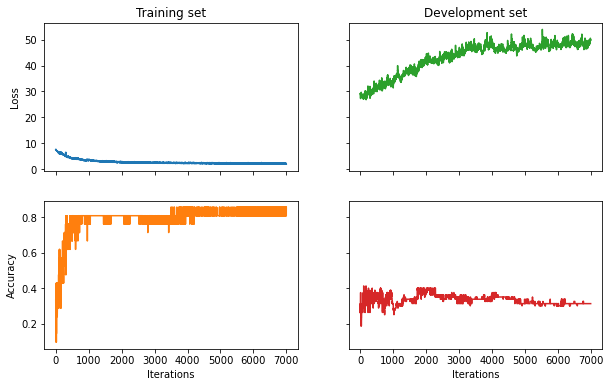

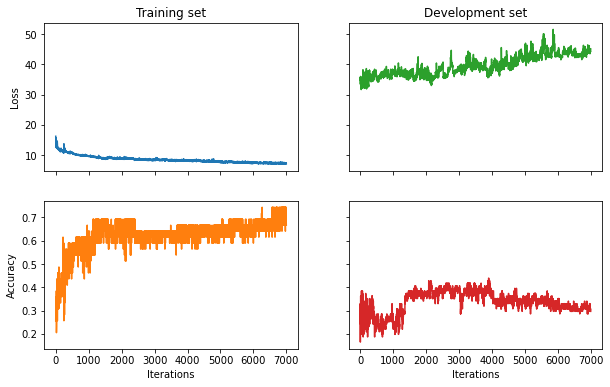

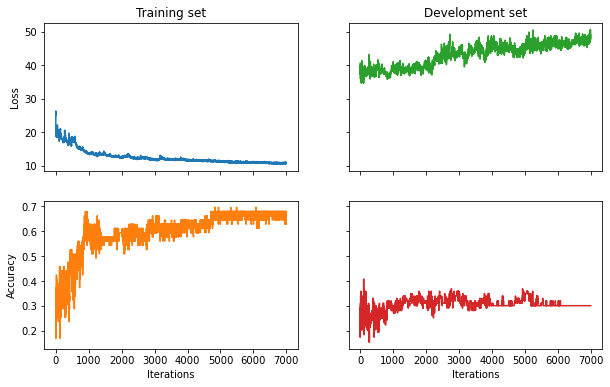

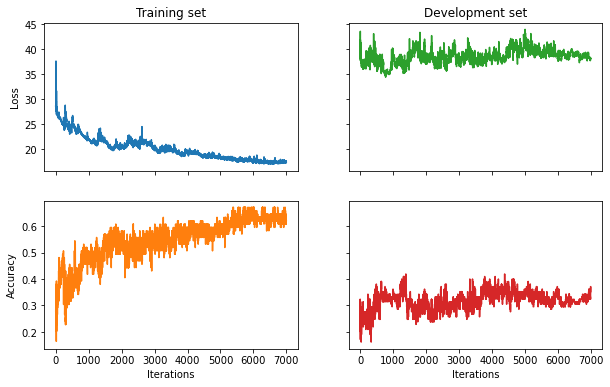

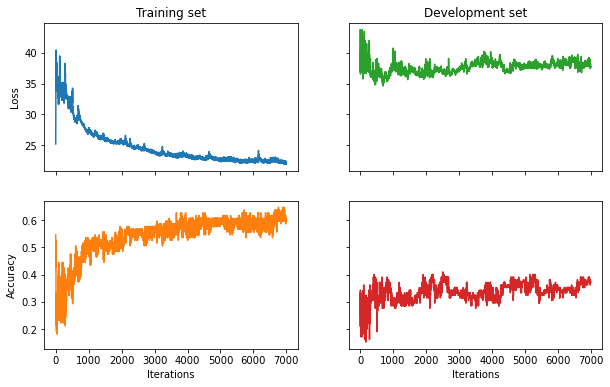

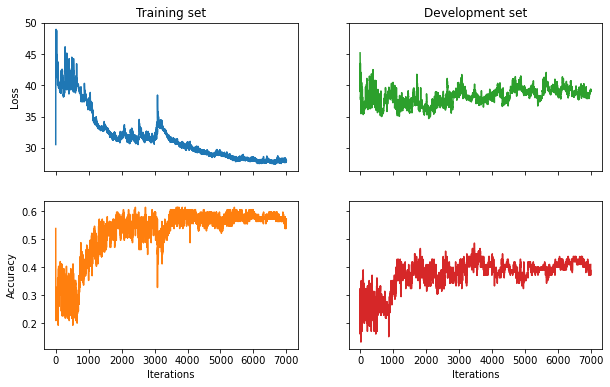

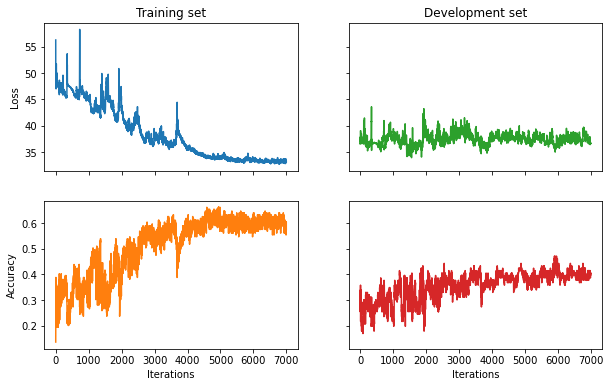

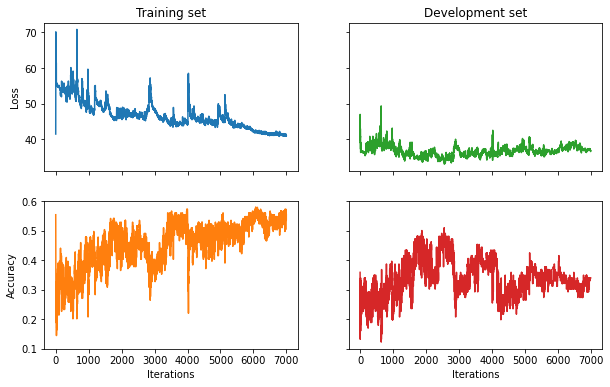

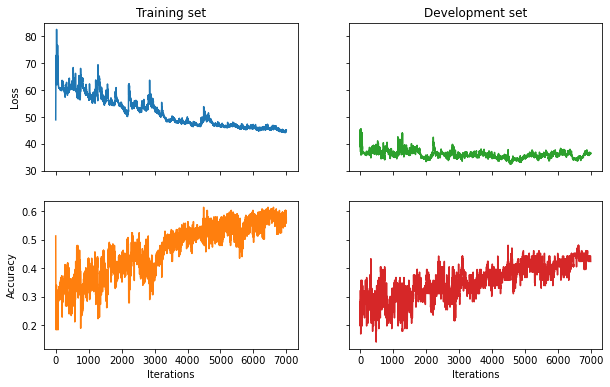

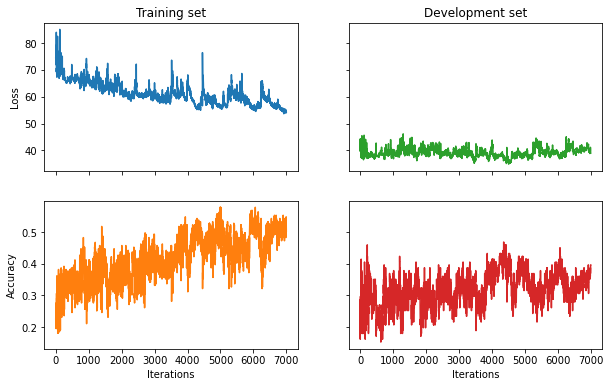

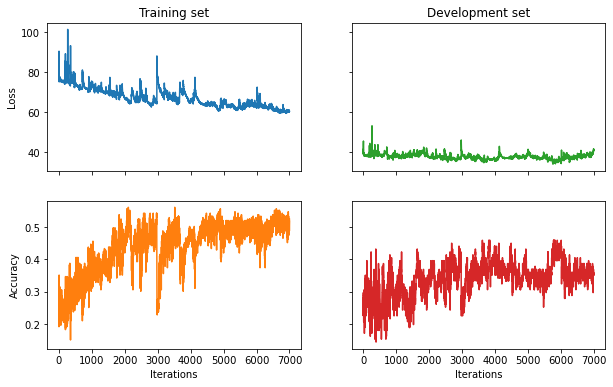

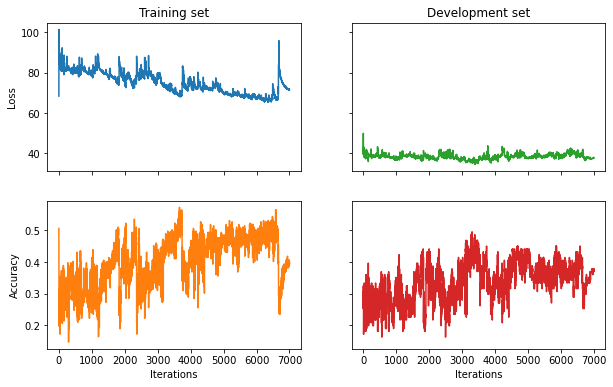

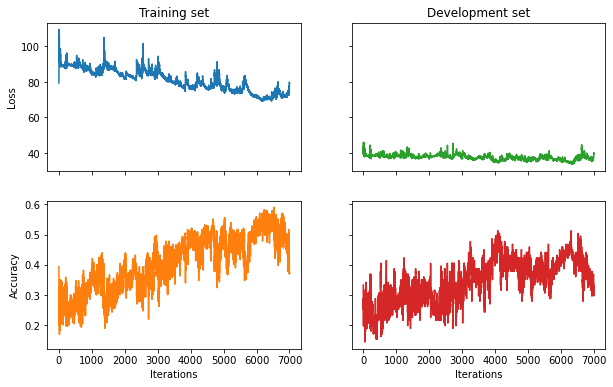

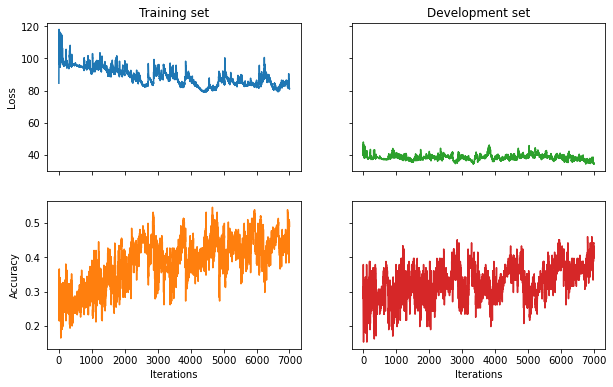

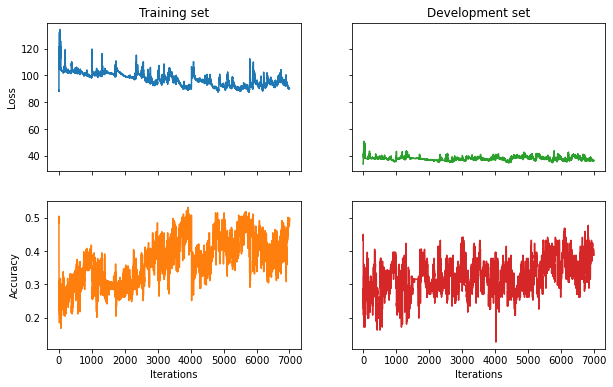

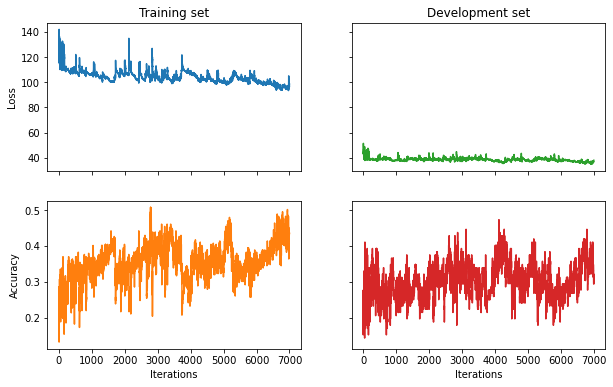

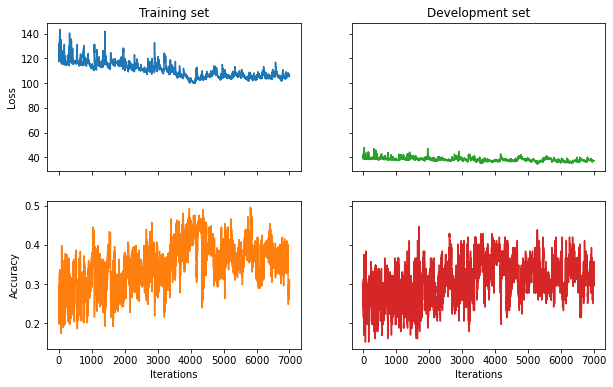

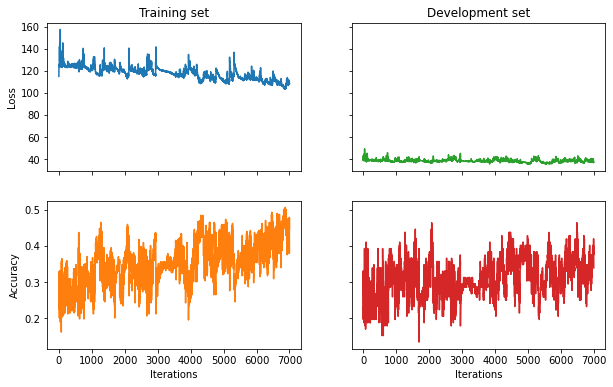

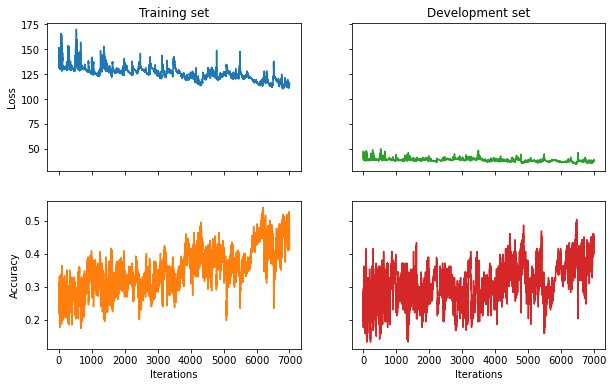

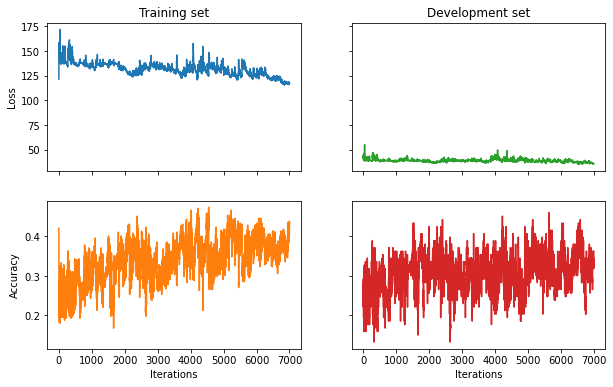

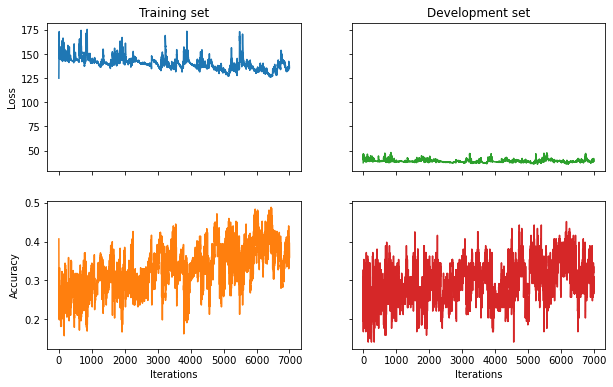

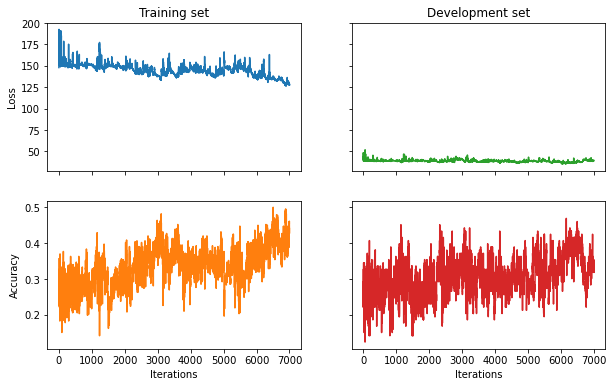

In [9]:
result = None

for i, key in enumerate(all_training_keys[initial_number_of_circuits:]):
    print("Progress: ", round((i + initial_number_of_circuits)/len(all_training_keys), 3))
    
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[1:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            if result:
                parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
                #continue
            else:
                syms = get_symbols(current_training_circuits)
                parameters = sorted(syms, key=default_sort_key)
                init_params_spsa = np.array(rng.random(len(parameters)))
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    if limit:
        val_test_circ_size = ceil(len(current_training_circuits))
        if len(current_validation_circuits) > val_test_circ_size:
            validation_circuits_l = validation_circuits_l[:val_test_circ_size]
            validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
        if len(current_test_circuits) > val_test_circ_size:
            test_circuits_l = test_circuits_l[:val_test_circ_size]
            test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    stats = f"Number of training circuits: {len(training_circuits_l)}   "\
        + f"Number of validation circuits: {len(validation_circuits_l)}   "\
        + f"Number of test circuits: {len(test_circuits_l)}   "\
        + f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}"
    
    with open("results//" + result_file + ".txt", "a") as f:
        f.write(stats + "\n")
    
    print(stats)
    
    optimization_interval = 20
    
    if result == None or run % optimization_interval == 0:
    
        train_pred_fn = jit(make_pred_fn(training_circuits_l))
        dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
        test_pred_fn = make_pred_fn(test_circuits_l)

        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

        def callback_fn(xk):
            #print(xk)
            valid_loss = dev_cost_fn(xk)
            train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
            train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
            valid_acc = numpy.around(float(dev_accs[-1]), 4)
            iters = int(len(train_accs)/2)
            if iters % 200 == 0:
                info = f"Epoch: {iters}   "\
                + f"train/loss: {train_loss}   "\
                + f"valid/loss: {numpy.around(float(valid_loss), 4)}   "\
                + f"train/acc: {train_acc}   "\
                + f"valid/acc: {valid_acc}"

                with open("results//" + result_file + ".txt", "a") as f:
                    f.write(info + "\n")

                print(info, file=sys.stderr)
            return valid_loss

        #a_value = 0.0053
        #c_value = 0.0185

        # Good
        #a_value = 0.053
        #c_value = 0.00185
        
        a_value = 0.01 #*(1/run)
        c_value = 0.01 #*(1/run)
        
        a_values = [0.1, 0.01, 0.001, 0.0001]
        c_values = [1, 0.1, 0.01, 0.001, 0.0001]
        
        print(a_value, c_value)
        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
        
        #for a_value in a_values:
        #    for c_value in c_values:
        #print(a_value, c_value)
        result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
        #result = minimizeCompass(train_cost_fn, x0=init_params_spsa, redfactor=2.0, deltainit=1.0, deltatol=0.001, feps=1e-15, errorcontrol=True, funcNinit=30, funcmultfactor=2.0, paired=True, alpha=0.05, callback=callback_fn)

        figure_path = this_folder + "//results//" + result_file + ".png"
        visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path, result_file)
    
    run += 1
    #EPOCHS += 100
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)